In [1]:
# -*- coding: utf-8 -*-
"""
Created on March 2025

@author: hwei
"""

import os
import gc
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
import innvestigate
# This is required for innvestigate and must be called before models are loaded.
tf.compat.v1.disable_eager_execution()
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras import regularizers
from keras.models import Model
from keras.layers import Dense,LeakyReLU, Dropout, Add, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import Callback
from matplotlib.colors import Normalize
from sklearn.preprocessing import FunctionTransformer
tf.keras.utils.set_random_seed(0)
tf.config.list_physical_devices('GPU')
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.engine.training_v1")
import xarray as xr
#import innvestigate
import scipy.io as sio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.signal import butter, sosfilt
from tensorflow.keras.models import load_model

2025-08-01 19:18:24.207232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-01 19:18:24.319151: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-01 19:18:24.352394: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
In_name = "TS_anom" #
Out_name = "TOA_anom" #



# Paths to the datasets
# file_hist = "E:\\Yue\\CESM2\\test\\test.CESM2-historical.ens-mean.ANN.1850-2014.new.nc"
# file_2xCO2 = "E:\\Yue\\test\\test.2xCO2.ANN.new.nc"
# file_4xCO2 = "E:\\Yue\\CESM2\\test\\test.CESM2-4xCO2.ANN.nc"

'''
######### CESM1 #########
file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.historical.ens-mean.ANN.1920-2100.new.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.4xCO2.ANN.new.nc"
######### CESM1 #########


'''
######### CESM2 #########
file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-historical.ens-mean.ANN.1850-2014.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
######### CESM2 #########

# === Load historical data ===
ds_hist = xr.open_dataset(file_hist)
print("Historical dataset loaded:", ds_hist)

Historical dataset loaded: <xarray.Dataset>
Dimensions:   (time: 165, lon: 288, lat: 192)
Coordinates:
  * time      (time) object 1850-06-16 00:00:00 ... 2014-06-16 00:00:00
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Data variables:
    TS        (time, lat, lon) float32 ...
    TS_anom   (time, lat, lon) float64 ...
    TOA       (time) float64 ...
    TOA_anom  (time) float64 ...
Attributes:
    ERF:      ERF = F - F_ctrl (from Isla's ERFMIP runs)
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu_CESM2.ipynb
    author:   Y. Dong, 04/02/2025


In [3]:
lat = ds_hist["lat"]
lon = ds_hist["lon"]

time_hist = ds_hist["time"] 

######### CESM2 #########
time_hist = [date.year for date in time_hist.values] #for C2 data
######### CESM2 #########

######### CESM1 #########
#time_hist = time_hist.values #for C1 data
######### CESM1 #########

TS_hist = ds_hist[In_name]
TOA_hist = ds_hist[Out_name].values

# === Load 2xCO2 data ===
# ds_2xCO2 = xr.open_dataset(file_2xCO2)
# print("2xCO2 dataset loaded:", ds_2xCO2)

# time_2xCO2 = ds_2xCO2["year"]
# TS_2xCO2 = ds_2xCO2[In_name]
# TOA_2xCO2 = ds_2xCO2[Out_name].values

# === Load 4xCO2 data ===
ds_4xCO2 = xr.open_dataset(file_4xCO2)
print("4xCO2 dataset loaded:", ds_4xCO2)


# time_4xCO2_coords = ds_4xCO2["year"]
# time_4xCO2 = time_4xCO2_coords.values


######### CESM2 #########
time_4xCO2 = ds_4xCO2["time"] 
time_4xCO2 = [date.year for date in time_4xCO2.values] #for C2 data
######### CESM2 #########
'''
######### CESM1 #########
time_4xCO2 = ds_4xCO2["year"] 
time_4xCO2 = time_4xCO2.values #C1 data
######### CESM1 #########
'''
TS_4xCO2 = ds_4xCO2[In_name]
TOA_4xCO2 = ds_4xCO2[Out_name].values

# Optional: Print shapes to verify
print("TS_hist shape:", TS_hist.shape)
# print("TS_2xCO2 shape:", TS_2xCO2.shape)
print("TS_4xCO2 shape:", TS_4xCO2.shape)

4xCO2 dataset loaded: <xarray.Dataset>
Dimensions:   (time: 150, lon: 288, lat: 192)
Coordinates:
  * time      (time) object 0001-06-16 00:00:00 ... 0150-06-16 00:00:00
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Data variables:
    TS        (time, lat, lon) float32 ...
    TS_anom   (time, lat, lon) float32 ...
    TOA       (time) float64 ...
    TOA_anom  (time) float64 ...
Attributes:
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu_CESM2.ipynb
TS_hist shape: (165, 192, 288)
TS_4xCO2 shape: (150, 192, 288)


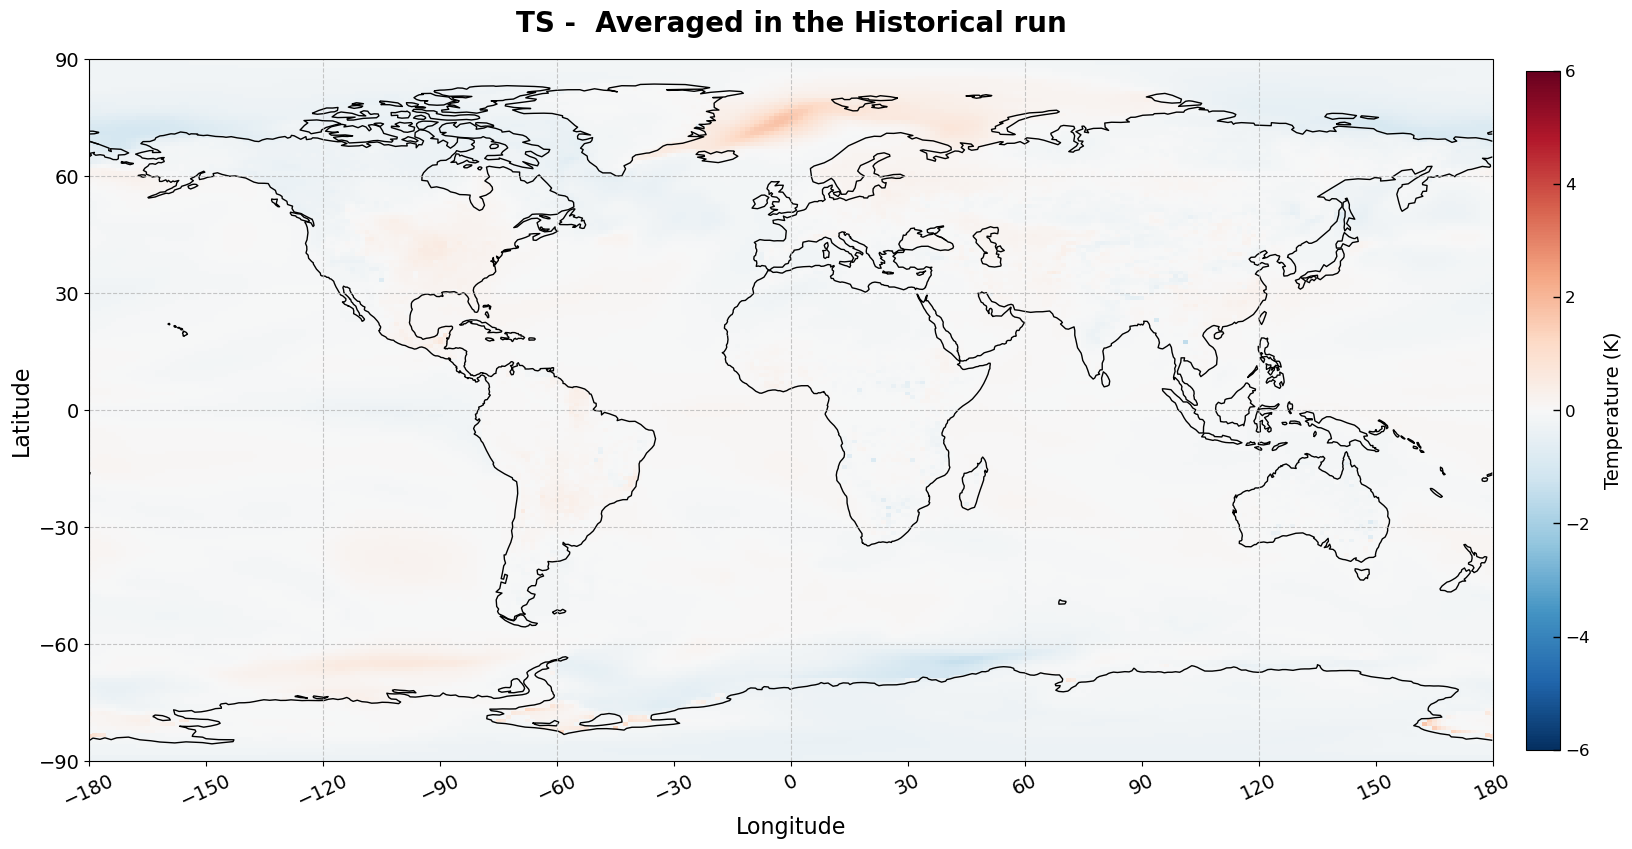

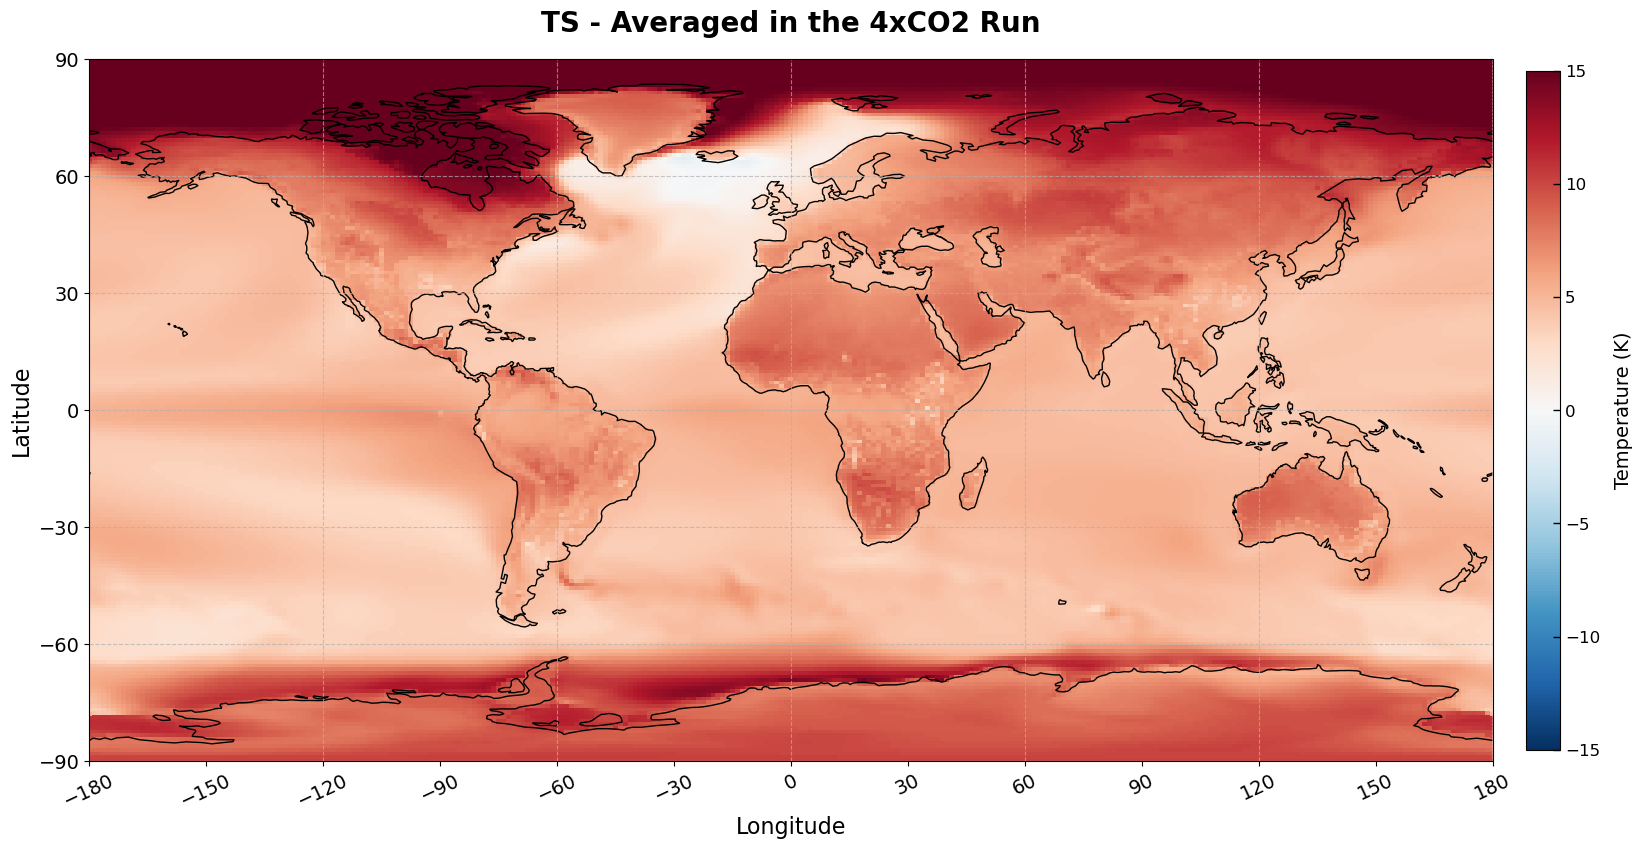

In [4]:
def plot_global_map(lon, lat, data2d, title, cbar_label="Temperature (K)", cmap="RdBu_r", vmin=None, vmax=None):
    """
    Plot a 2D global map using Cartopy with enhanced styling and colorbar.

    Parameters:
        lon (array): Longitudes
        lat (array): Latitudes
        data2d (2D array): Data to plot (must match lat/lon)
        title (str): Plot title
        cbar_label (str): Colorbar label
        cmap (str): Colormap
        vmin, vmax (float): Optional color scale limits
    """
    fig = plt.figure(figsize=(18, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot the data
    pcm = ax.pcolormesh(lon, lat, data2d, cmap=cmap, transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)

    # Add colorbar
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.02, shrink=0.8)
    cbar.set_label(cbar_label, fontsize=14, labelpad=10)
    cbar.ax.tick_params(labelsize=12, direction='in', length=5, width=1)

    # Coastlines and grid
    ax.coastlines(resolution="110m", linewidth=1)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlabel_style = {"size": 13}
    gl.ylabel_style = {"size": 13}

    # Axis ticks
    ax.set_xticks(range(-180, 181, 30), crs=ccrs.PlateCarree())
    ax.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.tick_params(axis="both", which="major", labelsize=14)
    plt.xticks(rotation=25, ha="center")

    # Title and labels
    ax.set_title(title, fontsize=20, fontweight="bold", pad=20)
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)

    plt.tight_layout()
    plt.show()





# Historical mean TS
plot_global_map(
    lon=lon,
    lat=lat,
    # data2d=np.mean(ds_hist[In_name], axis=0),
    data2d=ds_hist[In_name][0,:,:],
    title="TS -  Averaged in the Historical run",
    vmin=-6, vmax=6
)

# 2xCO2 mean TS
# plot_global_map(
#     lon=lon,
#     lat=lat,
#     data2d=np.mean(ds_2xCO2[In_name], axis=0),
#     title="TS - Averaged in the 2xCO2 Run",
#     vmin=-12, vmax=12
# )


# 4xCO2 mean TS
plot_global_map(
    lon=lon,
    lat=lat,
    data2d=np.mean(ds_4xCO2[In_name], axis=0),
    title="TS - Averaged in the 4xCO2 Run",
    vmin=-15, vmax=15
)



In [5]:
print("--- Debugging time_hist for CESM2 Historical ---")
if isinstance(time_hist, list) and time_hist: # Check if it's a non-empty list
    time_hist_np_check = np.array(time_hist) # Convert to NumPy array for min/max
    print(f"Min year in time_hist: {np.min(time_hist_np_check)}")
    print(f"Max year in time_hist: {np.max(time_hist_np_check)}")
    print(f"First 5 years: {time_hist_np_check[:5]}")
    print(f"Last 5 years: {time_hist_np_check[-5:]}")
else:
    print("time_hist is not a list or is empty.")

--- Debugging time_hist for CESM2 Historical ---
Min year in time_hist: 1850
Max year in time_hist: 2014
First 5 years: [1850 1851 1852 1853 1854]
Last 5 years: [2010 2011 2012 2013 2014]


In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy import ndimage # New import for spatial smoothing
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd # Add this import if not already present
from scipy import stats
import numpy as np

def calculate_trend_and_significance_temporal_smooth(relevance_data, time_axis, p_value_threshold=0.05, window_size=5):
    """
    Applies temporal smoothing (running mean) to relevance time series before
    calculating the linear trend and significance.
    'window_size' is the number of years for the running mean.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError("Time axis must be 1D and match the time dimension of data.")

    num_time, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)
    significance_mask = np.full((lat_dim, lon_dim), False, dtype=bool)

    print(f"    Calculating trends with temporal smoothing (window={window_size}) for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            
            if np.all(np.isfinite(relevance_timeseries)):
                # Apply temporal smoothing using a rolling mean
                # Using pandas for convenient rolling mean with handling of edges
                series = pd.Series(relevance_timeseries)
                smoothed_timeseries = series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
                
                # Filter out NaNs that might be introduced by rolling mean if window is large
                valid_indices = ~np.isnan(smoothed_timeseries)
                
                if np.sum(valid_indices) > 1: # Need at least 2 points for regression
                    current_time_axis = time_axis[valid_indices]
                    current_data = smoothed_timeseries[valid_indices]
                    
                    if len(current_data) > 1: # Still need at least 2 points after NaN removal
                        lin_reg_result = stats.linregress(x=current_time_axis, y=current_data)
                        trend_map[y, x] = lin_reg_result.slope
                        if lin_reg_result.pvalue < p_value_threshold:
                            significance_mask[y, x] = True
    print("    Trend and significance calculation with temporal smoothing complete.")
    return trend_map, significance_mask

def calculate_trend_and_significance(relevance_data, time_axis, p_value_threshold=0.1):
    """
    Calculates the linear trend (slope) and a significance mask
    at each grid cell over time.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError("Time axis must be 1D and match the time dimension of data.")

    _, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)
    significance_mask = np.full((lat_dim, lon_dim), False, dtype=bool) # Mask for significance

    print(f"    Calculating trends and significance for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            if np.all(np.isfinite(relevance_timeseries)) and len(relevance_timeseries) > 1:
                lin_reg_result = stats.linregress(x=time_axis, y=relevance_timeseries)
                trend_map[y, x] = lin_reg_result.slope
                if lin_reg_result.pvalue < p_value_threshold:
                    significance_mask[y, x] = True
    print("    Trend and significance calculation complete.")
    return trend_map, significance_mask

def apply_spatial_smoothing(data2d, sigma=1):
    """
    Applies a Gaussian filter to smooth a 2D map.
    Sigma is the standard deviation for Gaussian kernel.
    """
    print(f"    Applying spatial smoothing with sigma={sigma}...")
    smoothed_map = ndimage.gaussian_filter(data2d, sigma=sigma)
    print("    Smoothing complete.")
    return smoothed_map

In [7]:
ds_hist[In_name][0,:,:]

<xarray.DataArray 'TS_anom' (lat: 192, lon: 288)>
[55296 values with dtype=float64]
Coordinates:
    time     object 1850-06-16 00:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes:
    units:    K
    note:     TS_anom = TS_his - TS_ref
    ref:      B1850 yr1001-2000 mean

In [8]:
### load the mean and STD calculated in the Pre-industrial control run for normalization

# Paths to the datasets and trained model


########### CESM1 Model ##########
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom" #original model

#new model(1) -very good so far
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom" #wrong place but the model is for data 1

#corrected
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom"

#linear model C1
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_linear/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_linear+linear/TOA_anom/'

#change Gelu C1
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM1/Gelu_only/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+elu/TOA_anom'
#change PRelu C1
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM1/Prelu_only/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+PRelu/TOA_anom/'
######### CESM1 #########

########## CESM2 Model ######
#data1
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom"
#data1 model(1) gelu  
path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data1_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom"

#data 1 linear
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_linear(1)/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_linear+linear/TOA_anom"
#data 1 only changed Gelu
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/Gelu_data1)/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+elu/TOA_anom/'
#data 1 changed PRelu for 2nd layer
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/PRelu_data1/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+PRelu/TOA_anom/'

#data2 
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom"

#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom" #model gelu


#data 2 linear
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_linear(2)/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_linear+linear/TOA_anom'
#data 2 only change Gelu for 1st layer
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom/'
#data 2 only change PRelu for 2nd layer
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/PRelu_data2/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+PRelu/TOA_anom'
######### CESM2 #########

normalization= sio.loadmat(os.path.join(path_PIc, 'Normalization.mat'))

X_mean = normalization['X_mean']
X_std = normalization['X_std']
y_mean = normalization['y_mean']
y_std = normalization['y_std']


TS_hist_norm = (TS_hist-X_mean)/X_std.squeeze()
# TS_2xCO2_norm = (TS_2xCO2-X_mean)/X_std.squeeze()
TS_4xCO2_norm = (TS_4xCO2-X_mean)/X_std.squeeze()

TS_hist_norm = TS_hist_norm.values[..., tf.newaxis]
# TS_2xCO2_norm = TS_2xCO2_norm.values[..., tf.newaxis]
TS_4xCO2_norm = TS_4xCO2_norm.values[..., tf.newaxis]

print(X_mean)
print(X_std)

[[0]]
[[[0.68445126]
  [0.68444897]
  [0.6844508 ]
  ...
  [0.68444754]
  [0.68444868]
  [0.68445181]]

 [[0.72120212]
  [0.72106822]
  [0.72100594]
  ...
  [0.7214113 ]
  [0.72136638]
  [0.72132044]]

 [[0.74545226]
  [0.74505696]
  [0.74465021]
  ...
  [0.74649065]
  [0.74617489]
  [0.74582891]]

 ...

 [[0.97357658]
  [0.97572441]
  [0.97780851]
  ...
  [0.96810417]
  [0.96990093]
  [0.97162407]]

 [[0.94835836]
  [0.94916709]
  [0.95001042]
  ...
  [0.94568471]
  [0.94659858]
  [0.94750006]]

 [[0.93109743]
  [0.93116967]
  [0.93123528]
  ...
  [0.93083613]
  [0.93093159]
  [0.93101863]]]


In [9]:
from tensorflow.keras import backend as K
# load the neural network trained from Pre-industrial control simulation

n_folds = 5
n_ensembles = 1

pred_hist_ALL = np.empty((TOA_hist.shape[0],0))
# pred_2xCO2_ALL = np.empty((TOA_2xCO2.shape[0],0))
pred_4xCO2_ALL = np.empty((TOA_4xCO2.shape[0],0))


for fold_no in range(1,n_folds+1):

    pred_hist = np.zeros((TOA_hist.shape[0],1));
    # pred_2xCO2 = np.zeros((TOA_2xCO2.shape[0],1));
    pred_4xCO2 = np.zeros((TOA_4xCO2.shape[0],1));
    for ens_no in range(1,n_ensembles+1):
        K.clear_session() # Clears the Keras session and TensorFlow graph
        gc.collect()  
        Model = load_model(os.path.join(path_PIc,'model_fold'+str(fold_no)+'_ens'+str(ens_no)+'.h5'))
        pred_hist = pred_hist+ Model.predict(TS_hist_norm)
        # pred_2xCO2 = pred_2xCO2+ Model.predict(TS_2xCO2_norm)
        pred_4xCO2 = pred_4xCO2+ Model.predict(TS_4xCO2_norm)
        
    pred_hist = pred_hist/n_ensembles
    # pred_2xCO2 = pred_2xCO2/n_ensembles
    pred_4xCO2 = pred_4xCO2/n_ensembles


# re-scale the prediction from the neural network
    pred_hist = pred_hist*y_std + y_mean
    # pred_2xCO2 = pred_2xCO2*y_std + y_mean
    pred_4xCO2 = pred_4xCO2*y_std + y_mean



    pred_hist_ALL = np.concatenate(( pred_hist_ALL,pred_hist),axis = 1)
    # pred_2xCO2_ALL = np.concatenate(( pred_2xCO2_ALL,pred_2xCO2),axis = 1)
    pred_4xCO2_ALL = np.concatenate(( pred_4xCO2_ALL,pred_4xCO2),axis = 1)




2025-08-01 19:18:35.138647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-01 19:18:36.457359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2025-08-01 19:18:36.487363: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-08-01 19:18:38.750790: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2025-08-01 19:18:40.278812: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No suc

In [10]:
def plot_predictions(time, truth, preds, title):
    """
    Plots the ground truth, mean prediction, and individual model predictions with transparency.

    Parameters:
        time (array-like): Time axis values.
        truth (array-like): Ground truth values.
        preds (2D array): Predictions from ensemble or multiple models (shape: time x ensemble).
        title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot truth
    ax.plot(time, truth, label="Truth", color="C0", linewidth=2)

    # Plot mean prediction
    mean_pred = np.mean(preds, axis=1)
    ax.plot(time, mean_pred, label="Prediction (Mean)", color="C1", linewidth=1.8)

    # Plot individual models
    for i in range(preds.shape[1]):
        ax.plot(time, preds[:, i], linewidth=1, alpha=0.5,
                label="Prediction (CV" + str(i+1) + ")")

    # Style
    ax.set_xlabel("Time (Year)", fontsize=16)
    ax.set_ylabel(Out_name, fontsize=16)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_title(title, fontsize=18, pad=15)
    ax.legend(fontsize=14, loc="best")

    # R² annotation
    r2 = r2_score(truth, mean_pred)
    ax.text(0.02, 0.95, f"$R^2$ = {r2:.3f}", transform=ax.transAxes,
            fontsize=16, bbox=dict(facecolor="white", edgecolor="black", alpha=0.5))

    plt.tight_layout()
    plt.show()


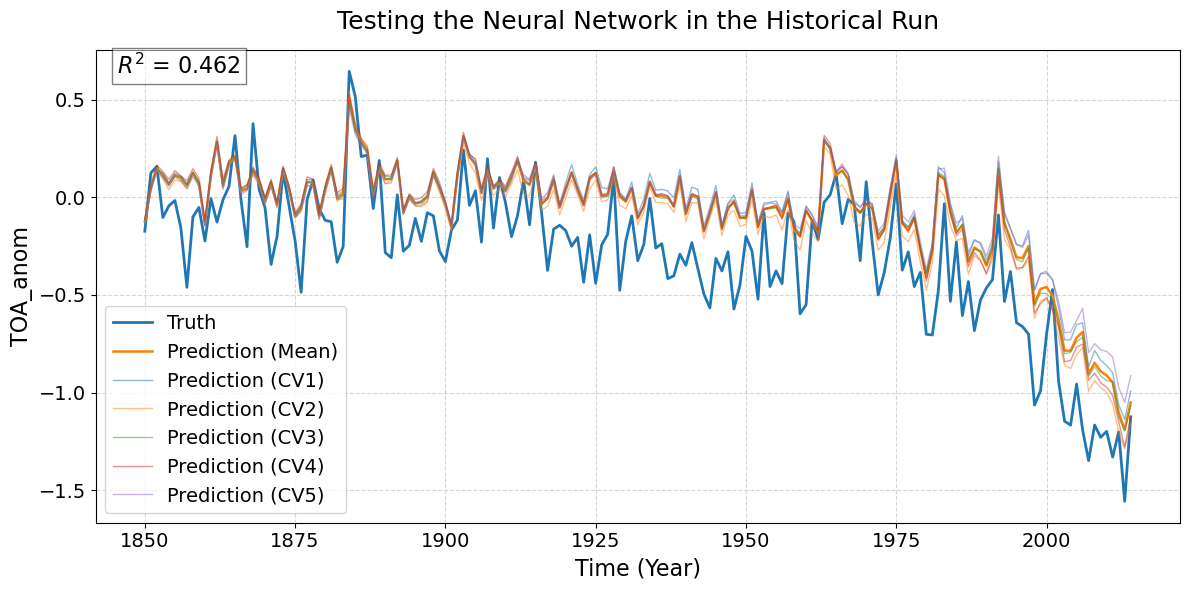

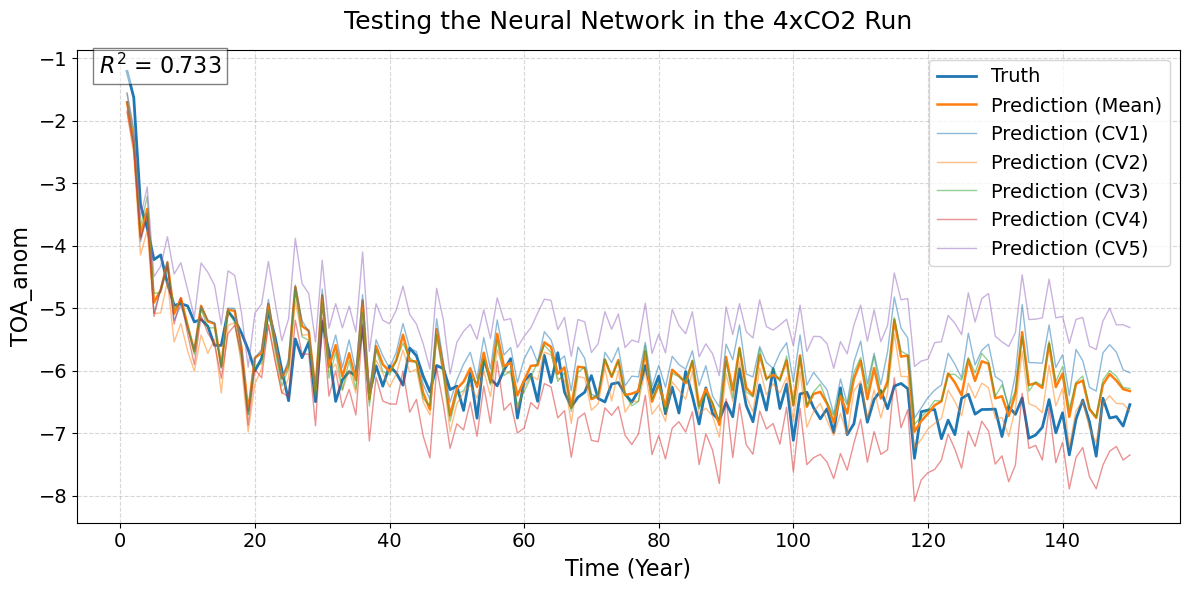

In [11]:
plot_predictions(time_hist, TOA_hist, pred_hist_ALL,
                 "Testing the Neural Network in the Historical Run")


#plot_predictions(time_2xCO2, TOA_2xCO2, pred_2xCO2_ALL,
#                  "Testing the Neural Network in the 2xCO2 Run")


plot_predictions(time_4xCO2, TOA_4xCO2, pred_4xCO2_ALL,
                 "Testing the Neural Network in the 4xCO2 Run")


In [12]:
def ensemble_lrp_analyze(model_dir, model_base_name, num_folds, data_to_analyze, analyzer_name='lrp.epsilon'):
    """
    Loads each model in a sequence, generates its LRP map, and returns the
    averaged map from all models. Handles session clearing internally.
    """
    all_relevance_maps = []
    print(f"\n--- Starting Ensemble LRP Analysis using '{analyzer_name}' ---")

    for i in range(1, num_folds + 1):
        # Clear the session before loading a new model to prevent graph conflicts
        tf.keras.backend.clear_session()
        gc.collect()

        model_path = os.path.join(model_dir, model_base_name.format(i))
        print(f"    Loading and analyzing model {i}/{num_folds}: {os.path.basename(model_path)}")

        try:
            # Load the model
            model = load_model(model_path)
            
            # Create an analyzer for this specific model
            analyzer = innvestigate.create_analyzer(analyzer_name, model)
            
            # Generate the relevance scores
            relevance = analyzer.analyze(data_to_analyze)
            all_relevance_maps.append(relevance)
            
        except Exception as e:
            print(f"      ❌ ERROR analyzing model {i}: {e}")
            continue

    if not all_relevance_maps:
        print("      LRP analysis failed for all models.")
        return None

    print("\n    Averaging relevance maps...")
    # Stack along a new axis and compute the mean
    ensemble_relevance = np.mean(np.stack(all_relevance_maps), axis=0)
    return ensemble_relevance

### RAW Matrix
try:
    print("\n======================================================")
    print("▶️ PROCESSING LRP FOR SCENARIO: HISTORICAL")
    print("======================================================")
    
    # The function returns the full [time, lat, lon] raw matrix
    averaged_lrp_hist = ensemble_lrp_analyze(
        model_dir=path_PIc,
        model_base_name='model_fold{}_ens1.h5',
        num_folds=n_folds,
        data_to_analyze=TS_hist_norm
    )
    
    if averaged_lrp_hist is not None:
        # ▼▼▼ THIS IS THE CODE THAT SAVES THE RAW MATRIX ▼▼▼
        output_filename_hist = "attribution_map_historical.npy"
        np.save(output_filename_hist, averaged_lrp_hist)
        print(f"✅ Raw relevance matrix saved to: {output_filename_hist}")
        # ▲▲▲ THIS IS THE CODE THAT SAVES THE RAW MATRIX ▲▲▲

except Exception as e:
    print(f"An unexpected ERROR occurred during Historical LRP processing: {e}")

# --- Process and Save for 4xCO2 Scenario ---
try:
    print("\n======================================================")
    print("▶️ PROCESSING LRP FOR SCENARIO: 4xCO2")
    print("======================================================")
    
    averaged_lrp_4xco2 = ensemble_lrp_analyze(
        model_dir=path_PIc,
        model_base_name='model_fold{}_ens1.h5',
        num_folds=n_folds,
        data_to_analyze=TS_4xCO2_norm
    )
    
    if averaged_lrp_4xco2 is not None:
        # ▼▼▼ THIS IS THE CODE THAT SAVES THE RAW MATRIX ▼▼▼
        output_filename_4xco2 = "attribution_map_4xCO2.npy"
        np.save(output_filename_4xco2, averaged_lrp_4xco2)
        print(f"✅ Raw relevance matrix saved to: {output_filename_4xco2}")
        # ▲▲▲ THIS IS THE CODE THAT SAVES THE RAW MATRIX ▲▲▲

except Exception as e:
    print(f"An unexpected ERROR occurred during 4xCO2 LRP processing: {e}")


▶️ PROCESSING LRP FOR SCENARIO: HISTORICAL

--- Starting Ensemble LRP Analysis using 'lrp.epsilon' ---
    Loading and analyzing model 1/5: model_fold1_ens1.h5


2025-08-01 19:18:47.819769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 2/5: model_fold2_ens1.h5


2025-08-01 19:18:49.809691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 3/5: model_fold3_ens1.h5


2025-08-01 19:18:51.294671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 4/5: model_fold4_ens1.h5


2025-08-01 19:18:52.804247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 5/5: model_fold5_ens1.h5


2025-08-01 19:18:54.240349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0



    Averaging relevance maps...
✅ Raw relevance matrix saved to: attribution_map_historical.npy

▶️ PROCESSING LRP FOR SCENARIO: 4xCO2

--- Starting Ensemble LRP Analysis using 'lrp.epsilon' ---
    Loading and analyzing model 1/5: model_fold1_ens1.h5


2025-08-01 19:18:55.806488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 2/5: model_fold2_ens1.h5


2025-08-01 19:18:57.286301: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 3/5: model_fold3_ens1.h5


2025-08-01 19:18:58.683159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 4/5: model_fold4_ens1.h5


2025-08-01 19:19:00.104266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 5/5: model_fold5_ens1.h5


2025-08-01 19:19:01.527037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0



    Averaging relevance maps...
✅ Raw relevance matrix saved to: attribution_map_4xCO2.npy



Starting LRP attribution analysis section...

▶️ PROCESSING LRP FOR SCENARIO: HISTORICAL

--- Starting Ensemble LRP Analysis using 'lrp.epsilon' ---
    Loading and analyzing model 1/5: model_fold1_ens1.h5


2025-08-01 19:19:03.071990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 2/5: model_fold2_ens1.h5


2025-08-01 19:19:04.517052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 3/5: model_fold3_ens1.h5


2025-08-01 19:19:05.936412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 4/5: model_fold4_ens1.h5


2025-08-01 19:19:07.372997: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 5/5: model_fold5_ens1.h5


2025-08-01 19:19:08.822148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0



    Averaging relevance maps...
✅ Averaged absolute attribution map saved to: attribution_map_historical_absolute.npy
    Displaying time-averaged ABSOLUTE relevance map...


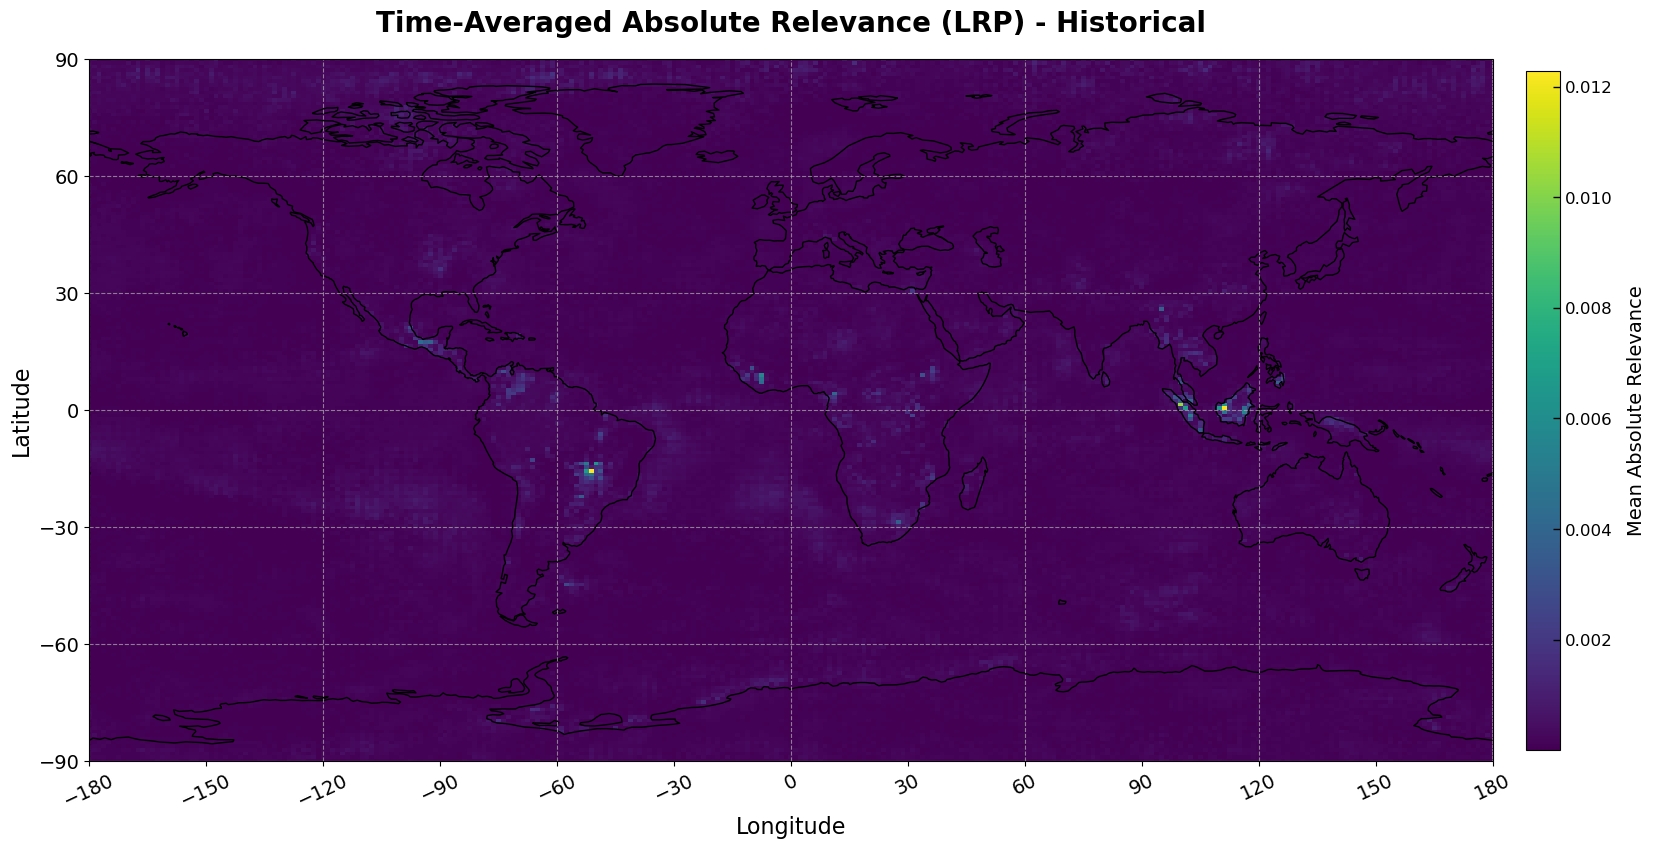


▶️ PROCESSING LRP FOR SCENARIO: 4xCO2

--- Starting Ensemble LRP Analysis using 'lrp.epsilon' ---
    Loading and analyzing model 1/5: model_fold1_ens1.h5


2025-08-01 19:19:11.231533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 2/5: model_fold2_ens1.h5


2025-08-01 19:19:12.619182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 3/5: model_fold3_ens1.h5


2025-08-01 19:19:14.018622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 4/5: model_fold4_ens1.h5


2025-08-01 19:19:15.431624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


    Loading and analyzing model 5/5: model_fold5_ens1.h5


2025-08-01 19:19:16.863887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31088 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0



    Averaging relevance maps...
✅ Averaged absolute attribution map saved to: attribution_map_4xCO2_absolute.npy
    Displaying time-averaged ABSOLUTE relevance map...


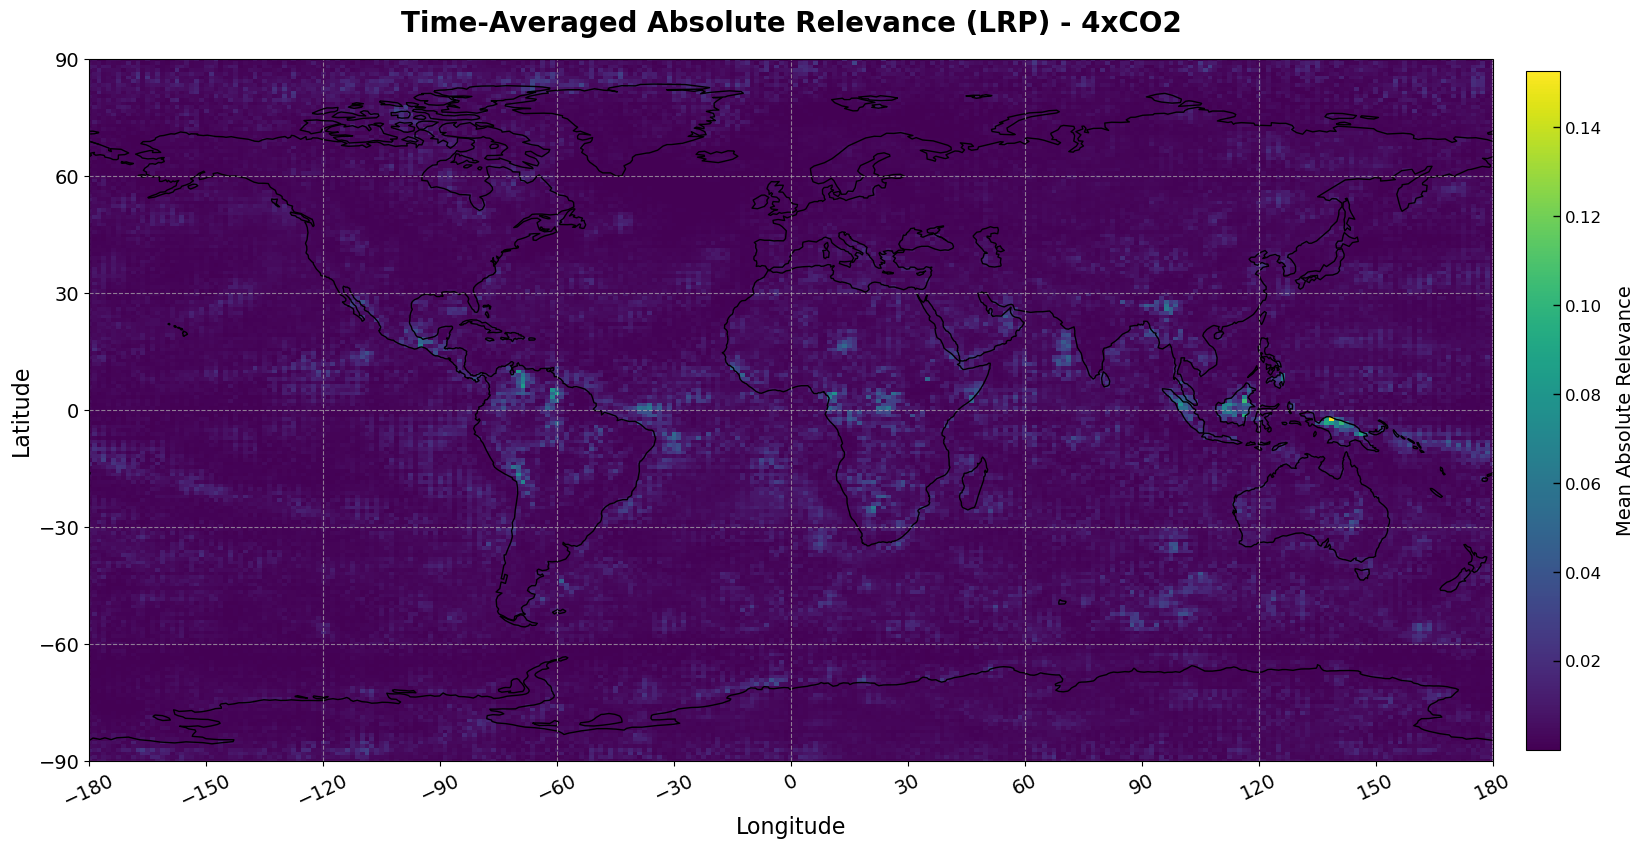

In [13]:
# ==========================================================
# LRP ENSEMBLE ATTRIBUTION ANALYSIS (Plotting Absolute Relevance)
# ==========================================================
print("\nStarting LRP attribution analysis section...")

# (The function definition for ensemble_lrp_analyze remains the same as before)

# --- Analyze the HISTORICAL scenario ---
print("\n======================================================")
print("▶️ PROCESSING LRP FOR SCENARIO: HISTORICAL")
print("======================================================")

averaged_lrp_hist = ensemble_lrp_analyze(
    model_dir=path_PIc,
    model_base_name='model_fold{}_ens1.h5',
    num_folds=n_folds,
    data_to_analyze=TS_hist_norm
)

if averaged_lrp_hist is not None:
    # --- NEW: Calculate the mean of the ABSOLUTE relevance values ---
    mean_abs_relevance_hist = np.mean(np.abs(averaged_lrp_hist), axis=0)
    
    # Save the absolute relevance map
    output_filename_hist = "attribution_map_historical_absolute.npy"
    np.save(output_filename_hist, mean_abs_relevance_hist)
    print(f"✅ Averaged absolute attribution map saved to: {output_filename_hist}")

    print("    Displaying time-averaged ABSOLUTE relevance map...")
    plot_global_map(
        lon=lon,
        lat=lat,
        data2d=mean_abs_relevance_hist[:, :, 0], # Correctly slice for 2D plot
        title="Time-Averaged Absolute Relevance (LRP) - Historical",
        cbar_label="Mean Absolute Relevance",
        cmap="viridis"  # Use a sequential colormap like viridis or plasma
    )

# --- Analyze the 4xCO2 scenario ---
print("\n======================================================")
print("▶️ PROCESSING LRP FOR SCENARIO: 4xCO2")
print("======================================================")

averaged_lrp_4xco2 = ensemble_lrp_analyze(
    model_dir=path_PIc,
    model_base_name='model_fold{}_ens1.h5',
    num_folds=n_folds,
    data_to_analyze=TS_4xCO2_norm
)

if averaged_lrp_4xco2 is not None:
    # --- NEW: Calculate the mean of the ABSOLUTE relevance values ---
    mean_abs_relevance_4xco2 = np.mean(np.abs(averaged_lrp_4xco2), axis=0)
    
    # Save the absolute relevance map
    output_filename_4xco2 = "attribution_map_4xCO2_absolute.npy"
    np.save(output_filename_4xco2, mean_abs_relevance_4xco2)
    print(f"✅ Averaged absolute attribution map saved to: {output_filename_4xco2}")

    print("    Displaying time-averaged ABSOLUTE relevance map...")
    plot_global_map(
        lon=lon,
        lat=lat,
        data2d=mean_abs_relevance_4xco2[:, :, 0], # Correctly slice for 2D plot
        title="Time-Averaged Absolute Relevance (LRP) - 4xCO2",
        cbar_label="Mean Absolute Relevance",
        cmap="viridis"
    )

1. Relevance map at each time step 
For each of the scenarios (historical or 4xCO2), compute the relevance map for each time step. Then you will have N snapshots, where N is the simulation length (in years). You could concatenate them into a large matrix with dimensions [time, lat, lon]. 

2. Trend analysis for the historical data 
For the historical scenario, using the above resulting matrix to compute the linear trend at each grid box across these snapshots over 1980-2020. (We already saw the decreasing trend in TOA anomaly during this period in your out-of-sample test last time.) A "linear trend" means the change in any targeted variable per unit time. So you'll need to compute the regression coefficient between the variable and the time interval at each grid box. The result should be a 2D trend map (lat, lon). 

3. Trend analysis for the 4xCO2 data 
Repeat the above analysis for the 4xCO2 scenario, but compute the linear trend over the full period (150 years, I believe). We’d want to compare the resulting trend maps between the two scenarios, to understand which regions of TS changes are driving the different evolutions of global TOA radiation between the past few decades vs. the future under increased CO2. 

In [14]:
'''
#CESM1#####
# ==========================================================
# RAW AND SMOOTHED RELEVANCE TREND ANALYSIS
# ==========================================================


print("\nStarting raw and smoothed trend analysis of attribution maps...")

from scipy import stats # Ensure this is imported
from scipy import ndimage # Ensure this is imported for spatial smoothing

def calculate_raw_trend_map(relevance_data, time_axis):
    """
    Calculates the linear trend (slope) at each grid cell over time.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    
    _, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)

    print(f"    Calculating raw trends for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            if np.all(np.isfinite(relevance_timeseries)) and len(relevance_timeseries) > 1:
                trend_map[y, x] = stats.linregress(x=time_axis, y=relevance_timeseries).slope
    print("    Raw trend calculation complete.")
    return trend_map

def apply_spatial_smoothing(data2d, sigma=1):
    """
    Applies a Gaussian filter to smooth a 2D map.
    Sigma is the standard deviation for Gaussian kernel.
    """
    print(f"    Applying spatial smoothing with sigma={sigma}...")
    # Ensure input is float for gaussian_filter if it contains NaNs
    data2d_float = data2d.astype(np.float64)
    # Handle NaNs: interpolate them or smooth a version where NaNs are 0, then re-mask
    # For simplicity here, we'll smooth and NaNs will propagate. 
    # A more sophisticated approach might be needed if NaNs are problematic.
    smoothed_map = ndimage.gaussian_filter(data2d_float, sigma=sigma)
    print("    Smoothing complete.")
    return smoothed_map

# --- 1. Load the previously generated LRP maps ---
try:
    lrp_hist = np.load("attribution_map_historical.npy").squeeze()
    lrp_4xco2 = np.load("attribution_map_4xCO2.npy").squeeze()
    print("✅ Successfully loaded .npy attribution maps.")
except FileNotFoundError:
    print("❌ ERROR: Could not find 'attribution_map_*.npy' files. Please run the LRP generation step first.")
    # exit() # Consider exiting if files are critical

# --- 2. Trend analysis for the historical data (1980-2020) ---
print("\n--- Processing Historical Trend (1980-2020) ---")
start_year_hist_trend = 1980
end_year_hist_trend = 2020
try:
    # Use the 'time_hist' variable (should be a NumPy array of years)
    start_index_hist_arr = np.where(time_hist == start_year_hist_trend)[0]
    end_index_hist_arr = np.where(time_hist == end_year_hist_trend)[0]
    
    if start_index_hist_arr.size == 0 or end_index_hist_arr.size == 0:
        raise ValueError(f"Year range {start_year_hist_trend}-{end_year_hist_trend} not found in historical time data.")
        
    start_idx = start_index_hist_arr[0]
    end_idx = end_index_hist_arr[0] + 1

    lrp_hist_sliced_trend = lrp_hist[start_idx:end_idx, :, :]
    time_hist_sliced_trend = time_hist[start_idx:end_idx]
    
    # Calculate raw trend map
    hist_raw_trend_map = calculate_raw_trend_map(lrp_hist_sliced_trend, time_hist_sliced_trend)
    plot_global_map(
        lon, lat, hist_raw_trend_map,
        title="Raw Linear Trend of Relevance (1980-2020) - Historical",
        cbar_label="Relevance Trend (per Year)"
    )
    
    # Apply spatial smoothing to the raw trend map
    hist_smoothed_trend_map = apply_spatial_smoothing(hist_raw_trend_map, sigma=1) # Adjust sigma as needed
    plot_global_map(
        lon, lat, hist_smoothed_trend_map,
        title="Spatially Smoothed Raw Trend of Relevance (1980-2020) - Historical",
        cbar_label="Relevance Trend (per Year)"
    )

except ValueError as e:
    print(f"ERROR processing historical trend: {e}")
except Exception as e:
    print(f"An unexpected ERROR occurred during historical trend processing: {e}")


# --- 3. Trend analysis for the 4xCO2 data (full period) ---
print("\n--- Processing 4xCO2 Trend (Full Period) ---")
try:
    # Use the 'time_4xco2' variable (should be a NumPy array of years)
    co2_raw_trend_map = calculate_raw_trend_map(lrp_4xco2, time_4xCO2)
    plot_global_map(
        lon, lat, co2_raw_trend_map,
        title=f"Raw Linear Trend of Relevance ({int(time_4xCO2[0])}-{int(time_4xCO2[-1])}) - 4xCO2",
        cbar_label="Relevance Trend (per Year)"
    )

    co2_smoothed_trend_map = apply_spatial_smoothing(co2_raw_trend_map, sigma=1) # Adjust sigma
    plot_global_map(
        lon, lat, co2_smoothed_trend_map,
        title=f"Spatially Smoothed Raw Trend of Relevance ({int(time_4xCO2[0])}-{int(time_4xCO2[-1])}) - 4xCO2",
        cbar_label="Relevance Trend (per Year)"
    )
except Exception as e:
    print(f"An unexpected ERROR occurred during 4xCO2 trend processing: {e}")
    '''

'\n#CESM1#####\n# ==========================================================\n# FINAL STEP: RAW AND SMOOTHED RELEVANCE TREND ANALYSIS\n# ==========================================================\n# This block assumes your script has already run, so variables like \'lon\',\n# \'lat\', \'time_hist\', and \'time_4xco2\' are already in memory.\n# It also assumes your \'plot_global_map\' function is defined and that\n# the \'attribution_map_*.npy\' files were created in the LRP generation step.\n\nprint("\nStarting raw and smoothed trend analysis of attribution maps...")\n\nfrom scipy import stats # Ensure this is imported\nfrom scipy import ndimage # Ensure this is imported for spatial smoothing\n\ndef calculate_raw_trend_map(relevance_data, time_axis):\n    """\n    Calculates the linear trend (slope) at each grid cell over time.\n    """\n    if relevance_data.ndim != 3:\n        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")\n    \n    _, lat_dim, lon_dim


Starting raw and spatially smoothed trend analysis of attribution maps...
✅ Successfully loaded .npy attribution maps.

--- Processing Historical Trend (1980-2014) ---
    Calculating raw trends for 192x288 grid...
    Raw trend calculation complete.


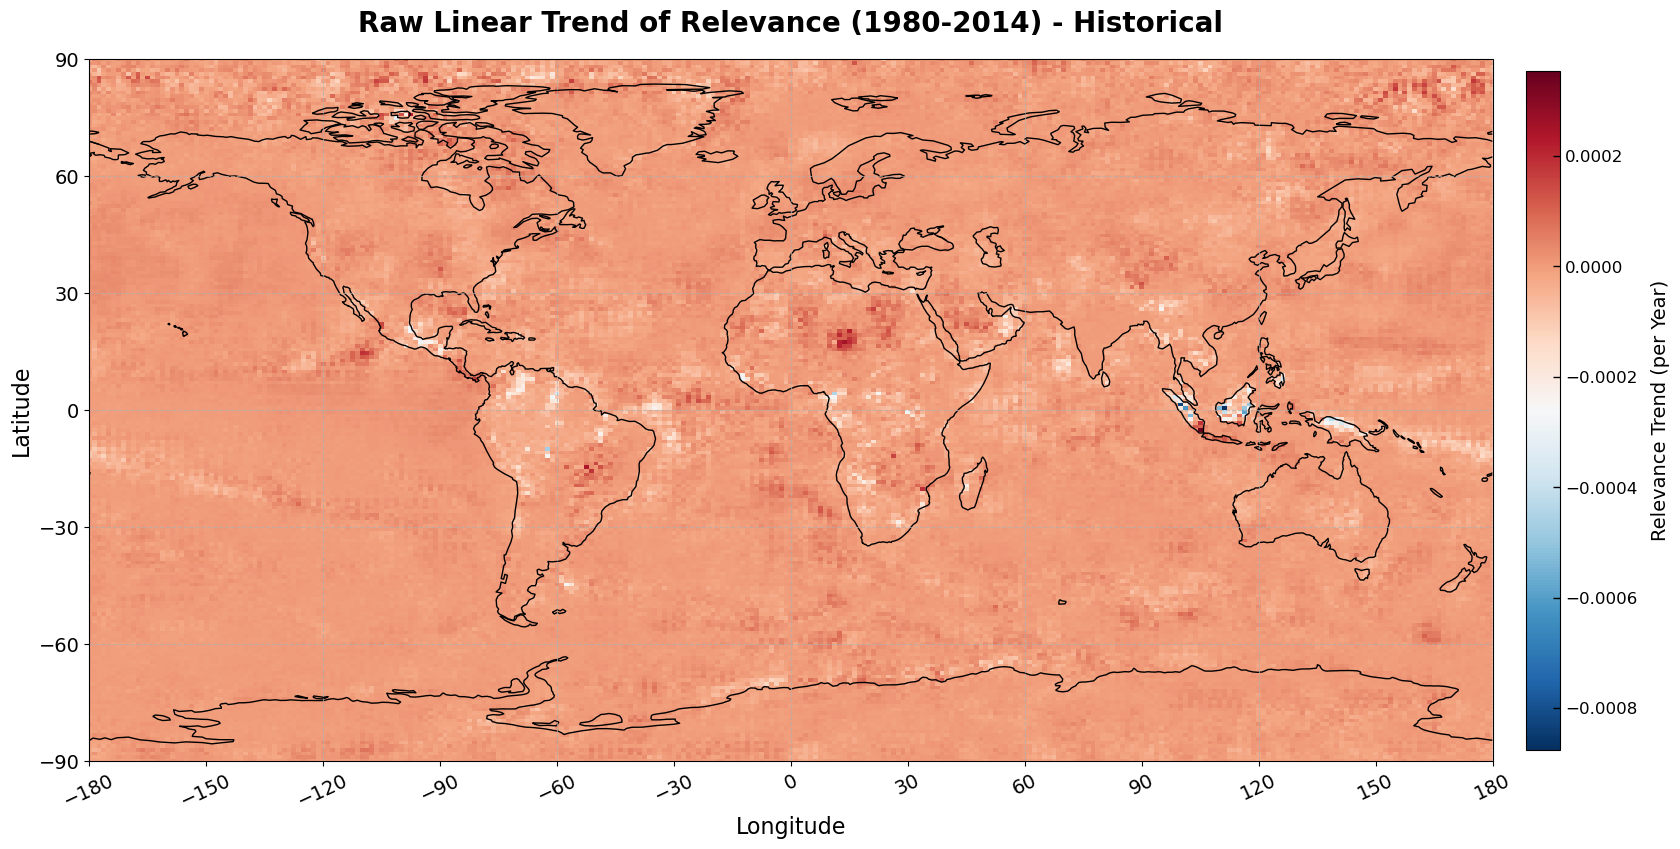

    Applying spatial smoothing with sigma=1...
    Smoothing complete.


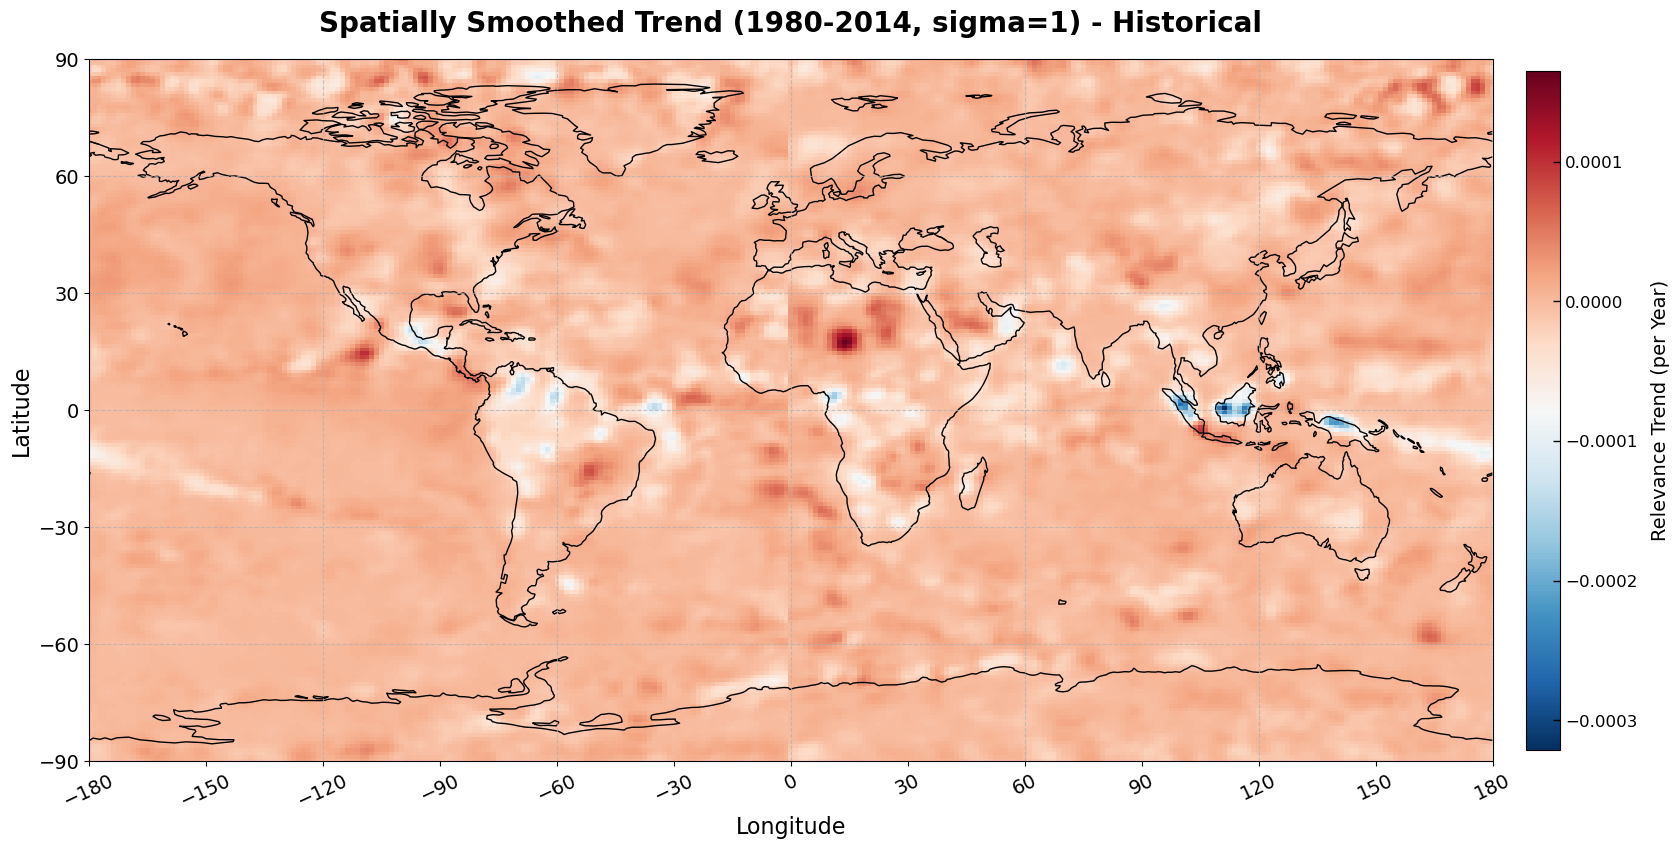


--- Processing 4xCO2 Trend (Full Period) ---
    Calculating raw trends for 192x288 grid...
    Raw trend calculation complete.


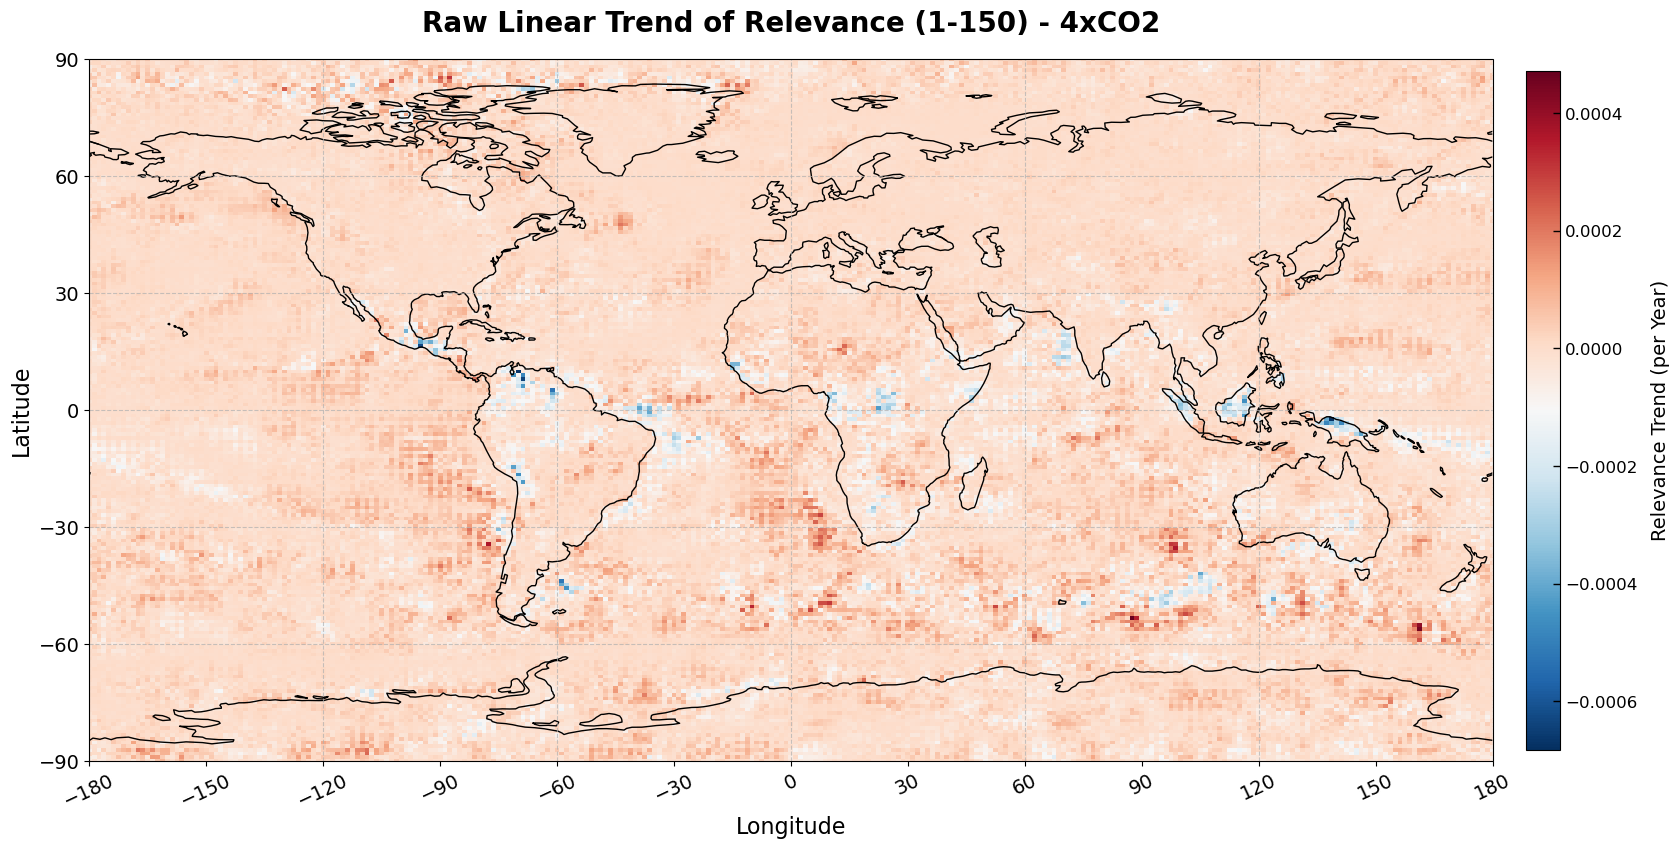

    Applying spatial smoothing with sigma=1...
    Smoothing complete.


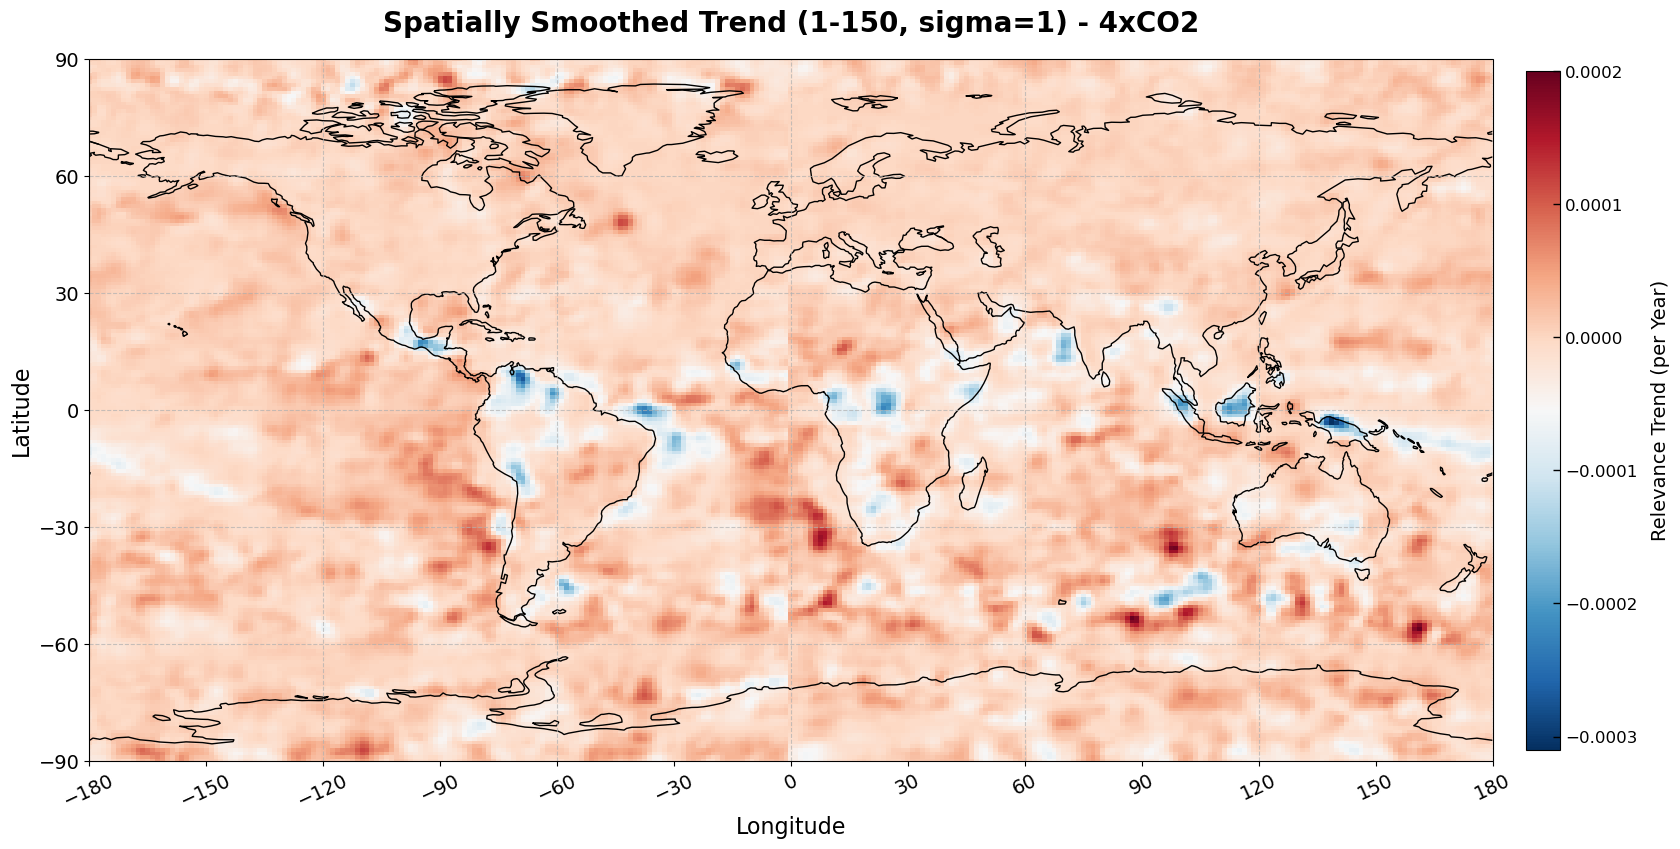

In [15]:
#CESM2
# ==========================================================
# FINAL STEP: RAW AND SPATIALLY SMOOTHED RELEVANCE TREND ANALYSIS
# ==========================================================
print("\nStarting raw and spatially smoothed trend analysis of attribution maps...")

from scipy import stats # Ensure this is imported
from scipy import ndimage # Ensure this is imported for spatial smoothing
import numpy as np # Ensure this is imported
import xarray as xr # Ensure this is imported for ds objects if needed for lat/lon

def calculate_raw_trend_map(relevance_data, time_axis):
    """
    Calculates the linear trend (slope) at each grid cell over time.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if not isinstance(time_axis, np.ndarray):
        time_axis = np.array(time_axis)
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError(f"Time axis (shape {time_axis.shape}) must be 1D and match the time dimension of data (shape {relevance_data.shape}).")
    
    _, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)

    print(f"    Calculating raw trends for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            if np.all(np.isfinite(relevance_timeseries)) and len(relevance_timeseries) > 1:
                trend_map[y, x] = stats.linregress(x=time_axis, y=relevance_timeseries).slope
    print("    Raw trend calculation complete.")
    return trend_map

def apply_spatial_smoothing(data2d, sigma=1):
    """
    Applies a Gaussian filter to smooth a 2D map.
    Sigma is the standard deviation for Gaussian kernel.
    """
    print(f"    Applying spatial smoothing with sigma={sigma}...")
    data2d_float = data2d.astype(np.float64) 
    # Handle NaNs by smoothing a copy where NaNs are 0, then re-applying mask
    # This is a simple way; more sophisticated inpainting could be used.
    nan_mask = np.isnan(data2d_float)
    data_to_smooth = np.where(nan_mask, 0, data2d_float)
    smoothed_map_temp = ndimage.gaussian_filter(data_to_smooth, sigma=sigma)
    smoothed_map = np.where(nan_mask, np.nan, smoothed_map_temp) # Put NaNs back
    print("    Smoothing complete.")
    return smoothed_map

# --- 1. Load the previously generated LRP maps ---
try:
    lrp_hist = np.load("attribution_map_historical.npy").squeeze()
    lrp_4xco2 = np.load("attribution_map_4xCO2.npy").squeeze()
    print("✅ Successfully loaded .npy attribution maps.")
except FileNotFoundError:
    print("❌ ERROR: Could not find 'attribution_map_*.npy' files. Please run the LRP generation step first.")
    # exit() # Consider exiting if files are critical

time_hist_np = np.array(time_hist)
time_4xCO2_np = np.array(time_4xCO2)

# --- 2. Trend analysis for the historical data (1980-2014) ---
print("\n--- Processing Historical Trend (1980-2014) ---")
start_year_hist_trend = 1980
end_year_hist_trend = 2014 
SMOOTHING_SIGMA = 1 

try:
    start_index_hist_arr = np.where(time_hist_np == start_year_hist_trend)[0]
    end_index_hist_arr = np.where(time_hist_np == end_year_hist_trend)[0]
    
    if start_index_hist_arr.size == 0:
        raise ValueError(f"Start year {start_year_hist_trend} not found in historical time data. Available: {np.min(time_hist_np)}-{np.max(time_hist_np)}")
    if end_index_hist_arr.size == 0:
        raise ValueError(f"End year {end_year_hist_trend} not found in historical time data. Available: {np.min(time_hist_np)}-{np.max(time_hist_np)}")
        
    start_idx = start_index_hist_arr[0]
    end_idx = end_index_hist_arr[0] + 1

    lrp_hist_sliced_trend = lrp_hist[start_idx:end_idx, :, :]
    time_hist_sliced_trend = time_hist_np[start_idx:end_idx]
    
    # Calculate and plot raw trend map
    hist_raw_trend_map = calculate_raw_trend_map(lrp_hist_sliced_trend, time_hist_sliced_trend)
    plot_global_map(
        lon, lat, hist_raw_trend_map,
        title=f"Raw Linear Trend of Relevance ({start_year_hist_trend}-{end_year_hist_trend}) - Historical",
        cbar_label="Relevance Trend (per Year)"
    )
    
    # Apply spatial smoothing to the raw trend map and plot it
    hist_smoothed_trend_map = apply_spatial_smoothing(hist_raw_trend_map, sigma=SMOOTHING_SIGMA)
    plot_global_map(
        lon, lat, hist_smoothed_trend_map,
        title=f"Spatially Smoothed Trend ({start_year_hist_trend}-{end_year_hist_trend}, sigma={SMOOTHING_SIGMA}) - Historical",
        cbar_label="Relevance Trend (per Year)"
    )

except ValueError as e:
    print(f"ERROR processing historical trend: {e}")
except Exception as e:
    print(f"An unexpected ERROR occurred during historical trend processing: {e}")


# --- 3. Trend analysis for the 4xCO2 data (full period) ---
print("\n--- Processing 4xCO2 Trend (Full Period) ---")
try:
    # Calculate and plot raw trend map
    co2_raw_trend_map = calculate_raw_trend_map(lrp_4xco2, time_4xCO2_np) # Use time_4xCO2_np
    plot_global_map(
        lon, lat, co2_raw_trend_map,
        title=f"Raw Linear Trend of Relevance ({int(time_4xCO2_np[0])}-{int(time_4xCO2_np[-1])}) - 4xCO2",
        cbar_label="Relevance Trend (per Year)"
    )

    # Apply spatial smoothing to the raw trend map and plot it
    co2_smoothed_trend_map = apply_spatial_smoothing(co2_raw_trend_map, sigma=SMOOTHING_SIGMA)
    plot_global_map(
        lon, lat, co2_smoothed_trend_map,
        title=f"Spatially Smoothed Trend ({int(time_4xCO2_np[0])}-{int(time_4xCO2_np[-1])}, sigma={SMOOTHING_SIGMA}) - 4xCO2",
        cbar_label="Relevance Trend (per Year)"
    )
except Exception as e:
    print(f"An unexpected ERROR occurred during 4xCO2 trend processing: {e}")